In [57]:
import os
import sys


import pandas as pd # to process data
import numpy as np # linear algebra
import datetime #to manipulate date formats
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for a better data visualization
import itertools # for list manipulation
import statsmodels.api as sm # for seasonal data exploration
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.tsa.api as smt
import scipy.stats as scs

p = print

p('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
p(sys.version)

Machine: Darwin x86_64

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### 1)Data Import: 
In this case six Comma-separated values (CSV) files:

In [2]:
items = pd.read_csv("competitive-data-science-predict-future-sales/items.csv")
item_categories = pd.read_csv("competitive-data-science-predict-future-sales/item_categories.csv")
sales_train = pd.read_csv("competitive-data-science-predict-future-sales/sales_train.csv")
sample_submission = pd.read_csv("competitive-data-science-predict-future-sales/sample_submission.csv")
shops = pd.read_csv("competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv("competitive-data-science-predict-future-sales/test.csv")

First of all let's have a short look on the data in each file:

In [3]:
#items
#sales_train
#item_categories
sales_train
#sample_submission
#shops
#test
#Depending on your region/country you could use this function to change date format:
#sales_train.date=sales_train.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [4]:
#Let's check data type
sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

Aggregate to monthly level the required metrics


In [5]:
sales_train_monthly = sales_train.drop(columns=["date"])

In [6]:
sales_train_monthly.groupby(["date_block_num","shop_id","item_id"]).sum().reset_index()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,0,32,884.0,6.0
1,0,0,33,1041.0,3.0
2,0,0,35,247.0,1.0
3,0,0,43,221.0,1.0
4,0,0,51,257.0,2.0
...,...,...,...,...,...
1609119,33,59,22087,357.0,6.0
1609120,33,59,22088,238.0,2.0
1609121,33,59,22091,179.0,1.0
1609122,33,59,22100,629.0,1.0


In [7]:
num_of_items_per_cat=items.merge(item_categories, on='item_category_id', how= "left")
num_of_items_per_cat

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра)
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,Игры PC - Цифра
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,Книги - Цифра
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,Книги - Методические материалы 1С
22168,Яйцо для Little Inu,22168,62,"Подарки - Гаджеты, роботы, спорт"


Let's join the items with their categories to show the category names

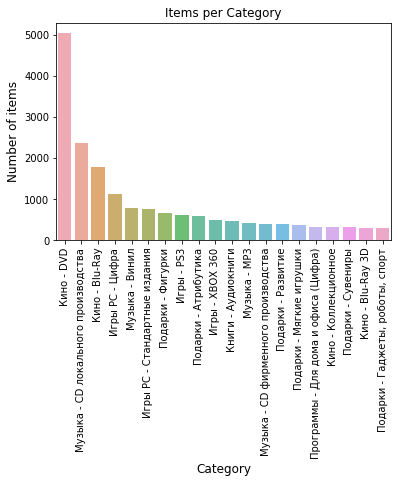

In [8]:
num_of_items_per_cat=items.merge(item_categories, on='item_category_id', how= "left") # Here we use a left join to import category names into our analysis
num_of_items_per_cat=num_of_items_per_cat.drop(columns="item_name").groupby(['item_category_name']).count().reset_index() # this group by is necessary to show the number of items in each category
num_of_items_per_cat=num_of_items_per_cat.sort_values(by='item_id',ascending=False) #we sort here by the number of items to show the categories with most items first
num_of_items_per_cat=num_of_items_per_cat.iloc[0:20] # we focus here only on the top 20 categories for a good visibility


ax= sns.barplot(x='item_category_name', y='item_id', alpha=0.8, data=num_of_items_per_cat, order=num_of_items_per_cat['item_category_name']) # we have used the order parameter to sort our bar plot 
plt.title("Items per Category")
plt.ylabel('Number of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90) # rotation of the text in the x axis
plt.show()

Let's calculate the sales value (gross sales), which could be also important for our analysis.

In [9]:
sales_train["sales_value"] = sales_train["item_cnt_day"] * sales_train["item_price"]
sales_train.head(100)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales_value
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
...,...,...,...,...,...,...,...
95,08.01.2013,0,25,2808,999.00,2.0,1998.00
96,09.01.2013,0,25,2808,999.00,1.0,999.00
97,11.01.2013,0,25,2808,999.00,4.0,3996.00
98,17.01.2013,0,25,2808,999.00,1.0,999.00


### Let's make an overview for our sales in units and values

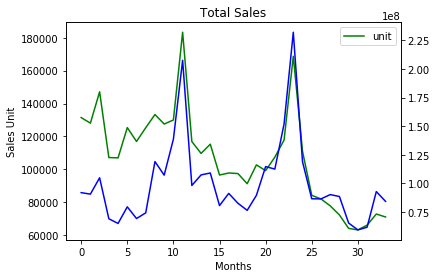

In [10]:
total_sales = sales_train.groupby(["date_block_num"])[["item_cnt_day","sales_value"]].sum()#.reset_index()
total_sales.astype('float')
plt.title('Total Sales')
plt.xlabel('Months')
plt.ylabel('Sales Unit')


sns.lineplot(data=total_sales.item_cnt_day, color="g", label="unit")
ax2 = plt.twinx()
sns.lineplot(data=total_sales.sales_value, color="b", ax=ax2)

#ax.figure.legend()
plt.show()

In [11]:
year= ["2013","2014","2015"]
year=list(itertools.chain.from_iterable(itertools.repeat(x, 12) for x in year))[:34]


saison = ["Winter","Winter","Spring","Spring","Spring","Summer","Summer","Summer","Autumn","Autumn","Autumn","Winter"]
saison= list(itertools.chain.from_iterable(itertools.repeat(saison, 3)))[:34]

months=["Jan","Feb","Mar","April","Mai","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
months= list(itertools.chain.from_iterable(itertools.repeat(months, 3)))[:34]
MonthasaName = pd.DataFrame({'asName':months,'saison':saison, 'year':year})
MonthasaName["date_block_num"]= list(range(0,34))


In [12]:
sales_per_saison=sales_train.merge(MonthasaName, on='date_block_num', how= "left") # Here I used a left join to import category names into our analysis

Let's make a good saisonaly/yearly overview:

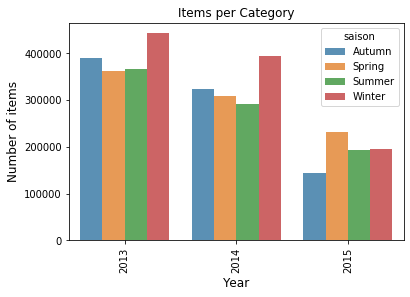

In [13]:
total_sales = sales_per_saison.groupby(["saison","year"])[["item_cnt_day"]].sum().reset_index()
#,"sales_value"
ax= sns.barplot(x='year', y='item_cnt_day',hue='saison', alpha=0.8, data=total_sales) # I have used the order parameter to sort our bar plot 
plt.title("Items per Category")
plt.ylabel('Number of items', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation=90) # rotation of the text in the x axis
plt.show()


We can see that the seasonal peak is in Winter - if we exclude 2015 where the data ends by October 2015.
Of course we can explore the data more than that, but let's look forward and aim the objective.
First that let's focus on understanding the monthly series -which I have choosen.

Let's decompose the time series divida in a way that we can separate its trend from its seasonal and residual components. for that we use the package statsmodels..


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


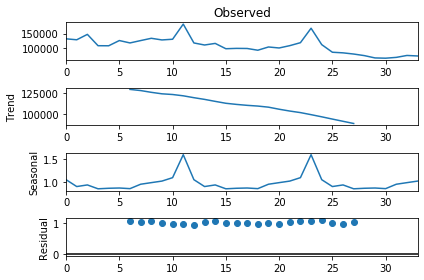

In [14]:
total_sales = sales_train.groupby(["date_block_num"])[["item_cnt_day"]].sum()#.reset_index()

# multiplicative
res = sm.tsa.seasonal_decompose(total_sales.values,freq=12,model="multiplicative")
fig = res.plot()


Now that we are pretty sure that we are facing seasonal data let's check if the data are stationary.
### Why is stationarity so important ?
In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time. [(S.Palachy, 2019)](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)
In other words the median, standard deviation and other indices are - or near - constant.
One of the most common test for stationariry is the Augmented Dickey Fuller Test (ADF) - [Here a simple usage of ADF in Excel.](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/)

To conclude a stationary time series (TS) is:
 - simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.
 - Most of the models we use in Time Series Analysis (TSA) assume covariance-stationarity. This means the descriptive statistics these models predict e.g. means, variances, and correlations, are only reliable if the TS is stationary and invalid otherwise.

In [30]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(total_sales)


Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


the p-value is over 5%, let's try to remove the trend and repeat the test.  
For that we need to define following functions:

In [31]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

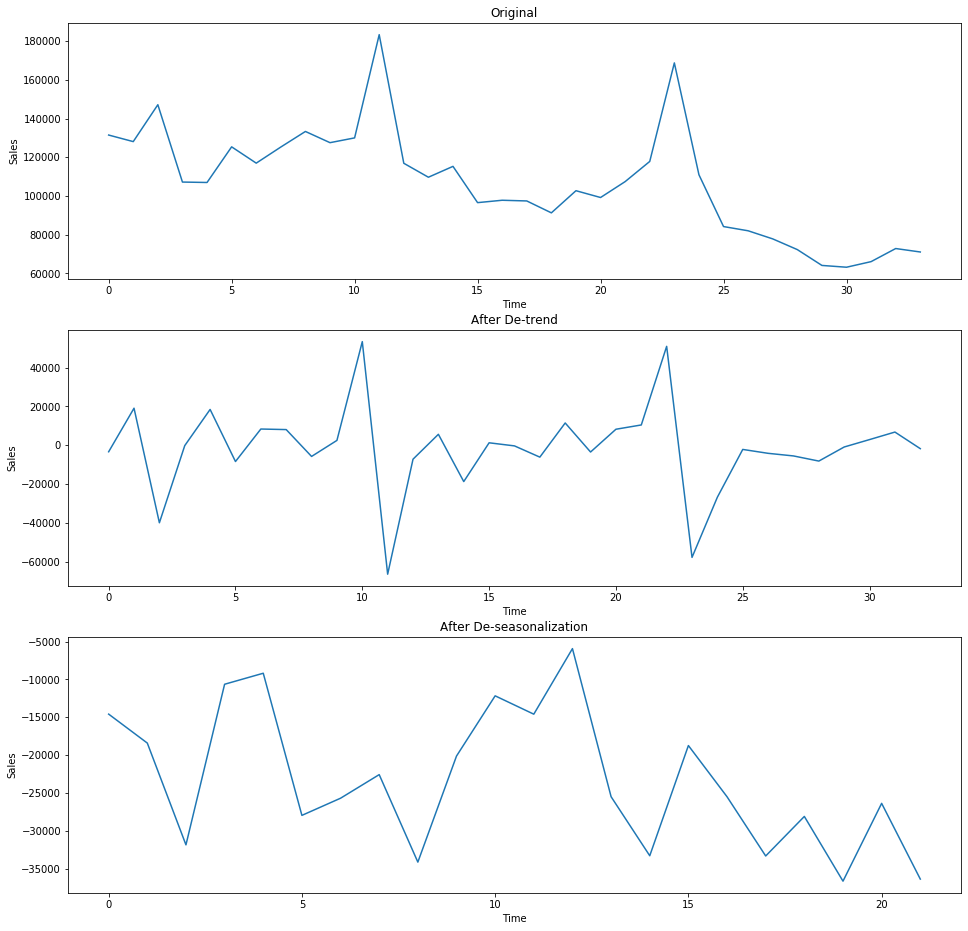

In [32]:
total_sales=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
total_sales.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(total_sales)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(total_sales)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(total_sales,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [16]:
test_stationarity(new_ts)


Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


Now the p-value is within 5% and so we can say that the transformation of the data was successfuly and the series is became stationary.

## White Noise

#### What is that?
A white noise process is a random process of random variables that are uncorrelated, have mean zero, and a finite variance.

Let's define a simulation of white Noise

In [33]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax, color='k')
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, color='r',alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, color='g',alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax, color='g')
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

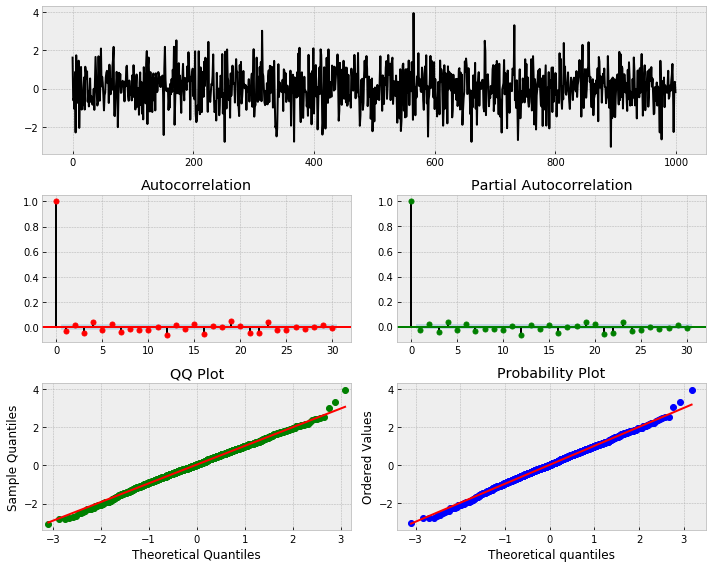

In [41]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

As expected the process appears to be random and centered about zero.
Let's do it in a different way and add a Random Walk.
#### What is a Random Walk?
![random-walk](images/random-walk.png)
- MICHAEL HALLS MOORE [QUANTSART.COM](https://www.quantstart.com/articles/White-Noise-and-Random-Walks-in-Time-Series-Analysis/)

### Autoregressive Models - AR(p)

let's apply it on an Auto Regressive, which look like:
![Auto Regressive](images/auto-regressive-p.png)


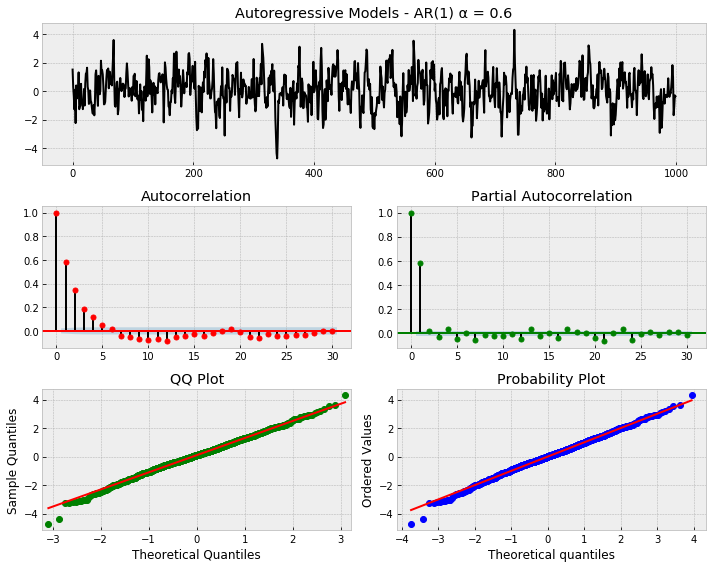

In [47]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=30    
_ = tsplot(x, lags=limit,title="Autoregressive Models - AR(1) α = 0.6")

For normally distributed data, observations should lie approximately on a straight line. If the data is non-normal, the points form a curve that deviates markedly from a straight line.  
So for Auto Regressive model with alpha = 0.6 looks - as expected - normal distributed.

Let's fit this model to our simulated data and see if the fitted model will select the correct lag. If the AR model is correct the estimated alpha should be close to the original one and the order will equal 1.

In [62]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
p('\nalpha estimate: {:3.5f} | best lag order = {}'
  .format(mdl.params[0], est_order))
p('\ntrue alpha = {} | true order = {}'
  .format(a, true_order))

CPU times: user 41.6 s, sys: 985 ms, total: 42.6 s
Wall time: 24.2 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


Well done! Let's simulate an AR(2) process with alpha_1 = 0.666 and alpha_2 = -0.333. For this we make use of statsmodel's "arma_generate_samples()" function. This function allows us to simulate an AR model of arbitrary orders. 
#### Notes that:
 - Python requires us to specify the zero-lag value which is 1
 - Also note that the alphas for the AR model must be negated
 - We also set the betas for the MA equal to 0 for an AR(p) model
 - For more information see the examples at statsmodels.org

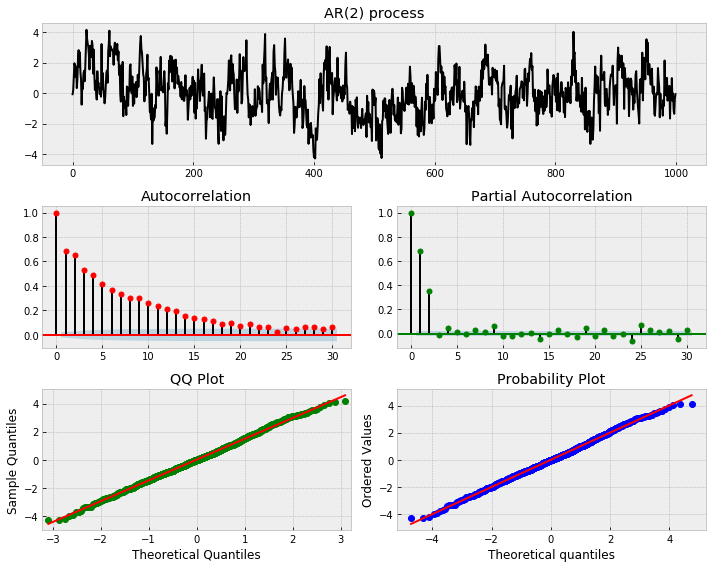

In [67]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# 
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30,title="AR(2) process")

In [69]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
p('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
  .format(mdl.params[0],mdl.params[1], est_order))
p('\ntrue coefs = {} | true order = {}'
  .format([.666,-.333], true_order))


coef estimate: 0.4441 0.3516 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


Looks not so bad. In practice any model with many parameters is unlikely to be useful.

### Moving Average (p)

Very similar to AR models with a small difference in the combination of past white noise error terms.
MA(p) model is a linear combination of past white noise error terms as opposed to a linear combo of past observations like the AR(p) model. 
The motivation for the MA model is that we can observe "shocks" in the error process directly by fitting a model to the error terms. In an AR(p) model these shocks are observed indirectly by using the ACF on the series of past observations. The formula for an MA(p) model is:
![Moving Average (p)](images/moving-average-p.png)

Let's simulate MA(1) process with a beta equals 0.8 and specifying the AR(p) alpha equal to 0.

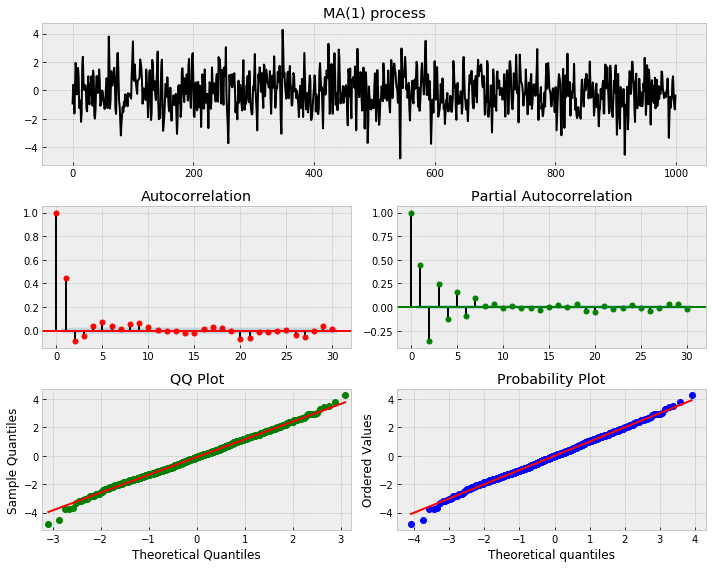

In [71]:
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.8])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=30
_ = tsplot(ma1, lags=limit,title="MA(1) process")

ACF and PACF show us difference lag significations

. Regardless we can now attempt to fit a MA(1) model to our simulated data. We can use the same statsmodels "ARMA()" function specifying our chosen orders. We call on its "fit()" method to return the model output. 

In [72]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1410.666
Method:                           mle   S.D. of innovations              0.991
Date:                Mon, 20 Apr 2020   AIC                           2825.333
Time:                        13:17:53   BIC                           2835.148
Sample:                             0   HQIC                          2829.063
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.7749      0.019     41.658      0.000       0.738       0.811
                                    Roots                                    
                  Real          Imaginary           M

The model was able to correctly estimate the lag coefficent as 0.77 is close to the original value (0.8). Also notice that our 95% confidence interval does contain the true value.  
Let's try simulating an MA(2) process, then use our ARMA function to fit a third order MA model to the series and see if we can recover the correct lag coefficients (betas). Betas 1-2 are equal to 0.6, 0.4 respectively.

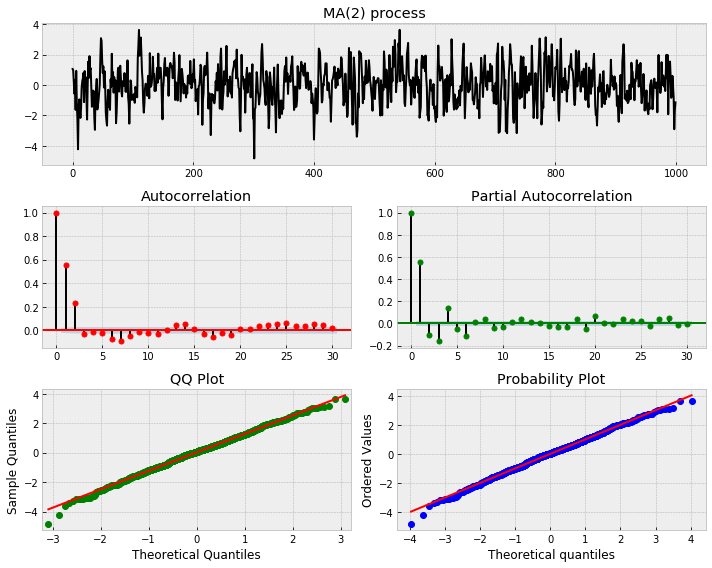

In [86]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30,title="MA(2) process")

In [81]:
# Fit MA(2) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 2)   Log Likelihood               -1459.718
Method:                           mle   S.D. of innovations              1.041
Date:                Mon, 20 Apr 2020   AIC                           2925.435
Time:                        13:29:26   BIC                           2940.158
Sample:                             0   HQIC                          2931.031
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6001      0.030     20.215      0.000       0.542       0.658
ma.L2.y        0.4011      0.028     14.505      0.000       0.347       0.455
                                    Roots           

The model was able to estimate the real coefficients effectively. Our 95% confidence intervals also contain the true parameter values of 0.6, 0.4. Now let's try fitting an MA(2) model to the SPY's log returns. Keep in mind we do not know the true parameter values.

### Autoregressive Moving Average Models - ARMA(p, q)

as the names can tell, the ARMA model is simply the merger between AR(p) and MA(q) models. Let's recap what these models represent to us from a quant finance perspective: 
 - AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets.
 - MA(q) models try to capture (explain) the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the observation process e.g. Surprise earnings, A terrorist attack, etc.


"For a set of products in a grocery store, the number of active coupon campaigns introduced at different times would constitute multiple 'shocks' that affect the prices of the products in question." [(P.Protopapas, 2014)](http://iacs-courses.seas.harvard.edu/courses/am207/blog/lecture-17.html)
ARMA's weakness is that it ignores the volatility clustering effects found in most financial time series. 

The model formula is:
![ARMAPQ](images/arma-pq.png)


Let's simulate an ARMA(2, 2) process with alphas=[0.5,-0.25] and betas=[0.5,-0.3]


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7053.737
Method:                           mle   S.D. of innovations              0.992
Date:                Mon, 20 Apr 2020   AIC                          14117.473
Time:                        13:58:35   BIC                          14150.059
Sample:                             0   HQIC                         14128.894
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4376      0.055      7.910      0.000       0.329       0.546
ar.L2.y       -0.2541      0.015    -17.077      0.000      -0.283      -0.225
ma.L1.y        0.5399      0.057      9.511      0.0

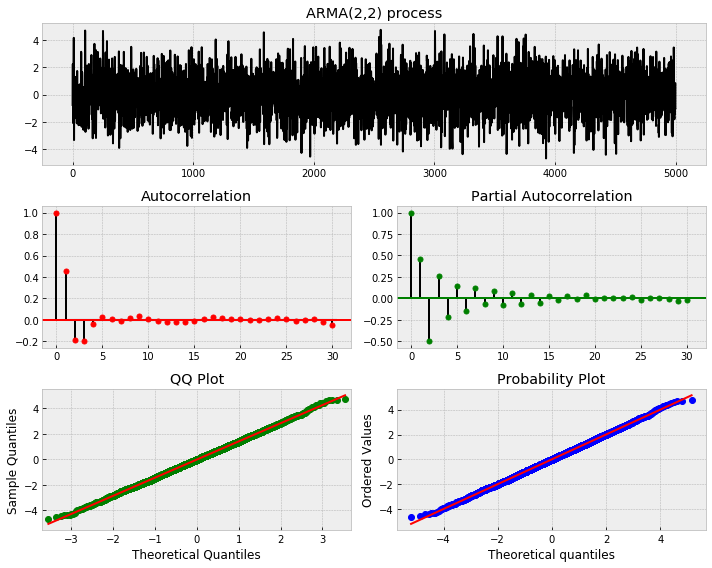

In [87]:
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
p(mdl.summary())

In [23]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


this table give a  nifty summary of the above plots:

![summary plots](images/summary-table.png)

In [88]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: 472.99703 | order: (1, 1)


In [24]:
# adding the dates to the Time-series as index
ts=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


## Let's check Prophet from Facebook:
Prophet is

To install please replace in the file fbprophet/hdays.py

by
from holidays import WEEKEND, HolidayBase
from dateutil.easter import easter
from dateutil.relativedelta import relativedelta as rd



In [90]:

from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [91]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957161,79983.251700,86253.821818
35,2015-12-01,125513.062787,122455.633020,128637.337496
36,2016-01-01,75625.688443,72333.598708,78601.521217
37,2016-02-01,40109.144323,36885.064191,43176.627907
38,2016-03-01,76664.084516,73665.387241,79658.082296


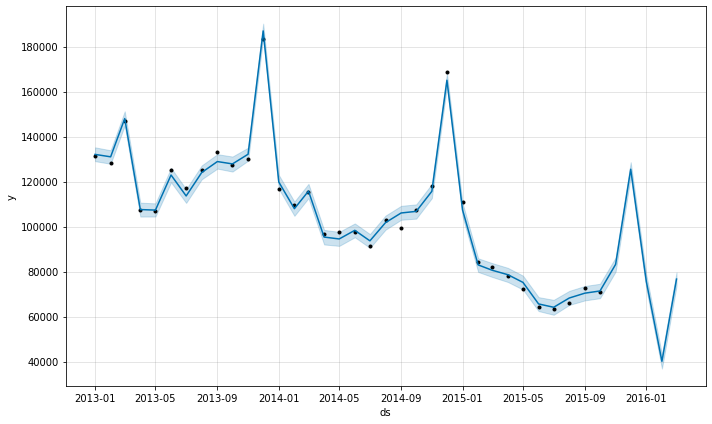

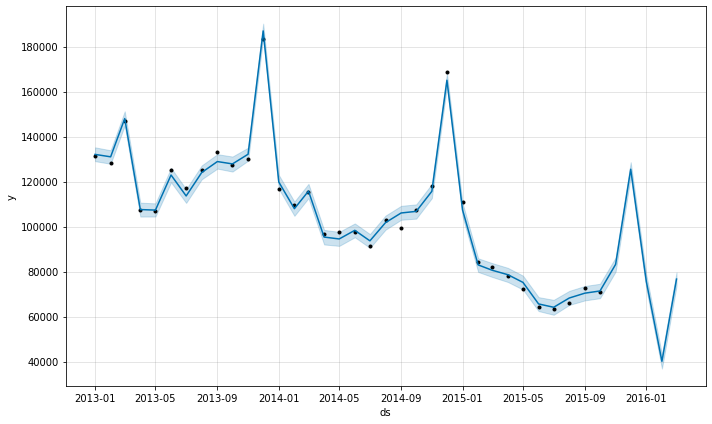

In [92]:
model.plot(forecast)

/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


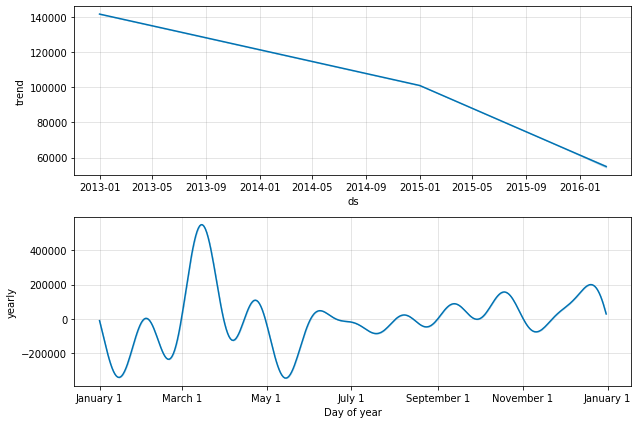

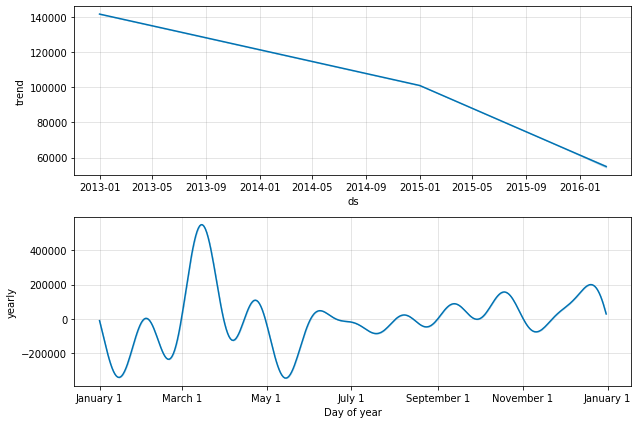

In [93]:
model.plot_components(forecast)


Awesome! The trend and seasonality from Prophet look similar to the ones that we had earlier using the traditional methods.
I'm planning to improve this script to process hierarchical TS and also consider UC Models.